In [2]:
# Manipulation de données 
import pandas as pd 
import numpy as np



# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns



# Preprocessing des reviews 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re



# Modélisation

    # Méthode classique
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
    
    # Méthodes avancées
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




# Pour enregistrer et charger les modèles
import joblib

# CHARGEMENT DES DONNEES

In [3]:
df_clean = pd.read_csv('Data/avis_ugc_fr.csv')

# PREPROCESSING

In [4]:
# Importation des stop words français de la librairie NLTK
stop_words = set(stopwords.words('french'))

# Ajout de stop words détectés dans les avis 
custom_stop_words = {",", ".", "a", "c'est", "!", "film", "cinéma", 
                     "si", "plus", "ugc", "ca", "là", "où", "deux", 
                     "ça", "h", "qu", "il", "''", '``', "-", "(", ")",
                     "..", "€", "?", "....", "//", ":", "/", ";", '’'
                    }
stop_words.update(custom_stop_words)

# Initialisation d'un lemmatiseur pour réduire les mots à leur forme de base
lemmatizer = WordNetLemmatizer()

def preprocess_reviews(reviews: pd.Series) -> pd.Series:
    """
    Cette fonction prend une série pandas contenant des avis textuels et applique un prétraitement
    pour chaque avis. Elle effectue les étapes suivantes :
    
    1. Convertit chaque avis en minuscules pour uniformiser le texte.
    2. Supprime les chiffres et remplace les apostrophes par des espaces pour éviter les séparations incorrectes.
    3. Tokenise chaque avis, c'est-à-dire qu'elle divise le texte en mots individuels.
    4. Supprime les stop words (mots courants sans importance) à partir d'une liste de stop words standard en français,
       enrichie de mots spécifiques au contexte.
    5. Applique la lemmatisation, qui réduit les mots à leur forme de base (par exemple, "films" devient "film").
    
    Paramètres :
    reviews (pd.Series) : Série pandas contenant les avis textuels.
    
    Retourne :
    pd.Series : Série pandas contenant des listes de mots prétraités pour chaque avis.
    """    
    
    # Convertir en minuscules et supprimer les chiffres et les apostrophes
    reviews = reviews.str.lower().str.replace(r'\d+', '', regex=True).str.replace("'", ' ')

    # Appliquer tokenisation, suppression des stop words, et lemmatisation
    reviews = reviews.apply(lambda review: [lemmatizer.lemmatize(word) 
                                            for word in word_tokenize(review) 
                                            if word not in stop_words
                                           ])


    return reviews

In [5]:
reviews = preprocess_reviews(df_clean['review'])

# MODELISATION : Prédiction de la satisfaction client en fonction de son avis

## Méthode classique (TF-IDF)

* Avant de commencer le travail de classification, on vérifie si les classes sont déséquilibrées

In [6]:
# transformation des avis en une liste de texte
reviews = [' '.join(review) for review in reviews]

# On applique la transformation TF-IDF aux avis pour obtenir une matrice sparse des scores TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(reviews)

In [7]:
df_clean['rating'].value_counts()

rating
5    27540
4    21394
3    11114
1     8842
2     5624
Name: count, dtype: int64

* On remarque un déséquilibre des classes assez marqué, notamment pour les notes faibles.

In [8]:
y = df_clean['rating'].map(lambda x : x-1) # XGBoost attend que les classes commencent par 0

# Séparation des données en un ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

### XGBoost sans réequilibrage des classes

c:\Users\Kyliv\DATA_PROJECT\UGC_project\ugc_project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1726
           1       0.64      0.26      0.36      1094
           2       0.56      0.35      0.43      2273
           3       0.51      0.46      0.49      4410
           4       0.59      0.82      0.69      5400

    accuracy                           0.58     14903
   macro avg       0.61      0.51      0.53     14903
weighted avg       0.58      0.58      0.57     14903



"joblib.dump(xgb, 'Entrainement_modeles_tfidf/xgb_tfidf.joblib')"

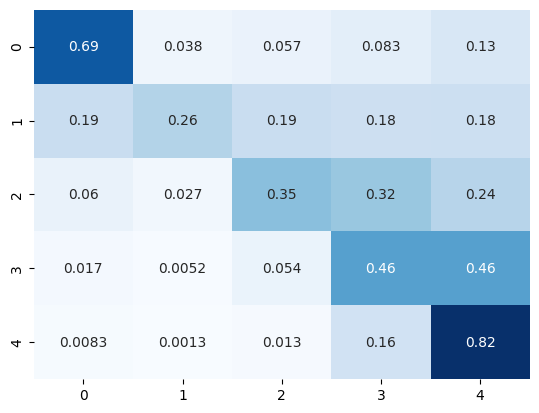

In [9]:
# Entrainement d'un modèle XGBoost 
"""xgb = XGBClassifier()
xgb.fit(X_train, y_train)"""

xgb = joblib.load('Entrainement_modeles_tfidf/xgb_tfidf.joblib')

# Affichage des scores
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

"""joblib.dump(xgb, 'Entrainement_modeles_tfidf/xgb_tfidf.joblib')"""

### XGBoost avec réequilibrage des classes

#### Cluster centroide

In [10]:
"""cc = ClusterCentroids(random_state=24)
X_train_resampled_cc, y_train_resampled_cc = cc.fit_resample(X_train, y_train)
"""
X_train_resampled_cc, y_train_resampled_cc = joblib.load('Entrainement_modeles_tfidf/ClusterCentroids_Ressample_tfidf.joblib')

"""joblib.dump((X_train_resampled_cc, y_train_resampled_cc), 'Entrainement_modeles_tfidf/ClusterCentroids_Ressample_tfidf.joblib')"""

"joblib.dump((X_train_resampled_cc, y_train_resampled_cc), 'Entrainement_modeles_tfidf/ClusterCentroids_Ressample_tfidf.joblib')"

* Le Cluster Centroid est un algorithme efficace d'undersampling, capable de réduire la taille des données tout en conservant une bonne représentativité des classes. Cependant, il est très coûteux en termes de temps de calcul et n’apporte pas d'amélioration significative mon cas (on à en réalité les mêmes résultats). J'ai donc choisi de rester sur une méthode plus naïve : le Random Under Sampling.

#### Random Under Sampling

In [11]:
rus = RandomUnderSampler(random_state=24)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1726
           1       0.29      0.59      0.39      1094
           2       0.44      0.43      0.43      2273
           3       0.51      0.41      0.45      4410
           4       0.66      0.62      0.64      5400

    accuracy                           0.53     14903
   macro avg       0.51      0.55      0.52     14903
weighted avg       0.55      0.53      0.54     14903



"joblib.dump(xgb_ressampled, 'Entrainement_modeles_tfidf/xgb_ressampled_tfidf.joblib')"

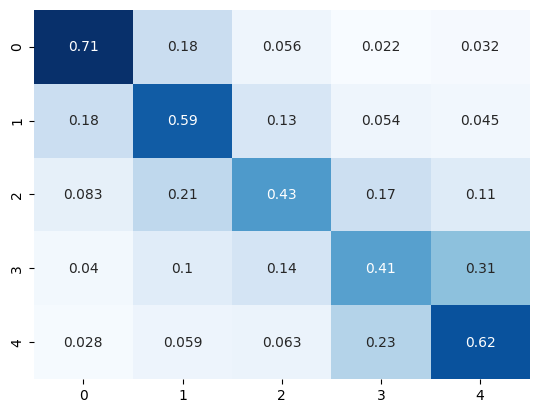

In [12]:
# Entraînement du modèle avec les classes rééquilibrées
"""xgb_ressampled = XGBClassifier()
xgb_ressampled.fit(X_train_resampled, y_train_resampled)"""

xgb_ressampled = joblib.load('Entrainement_modeles_tfidf/xgb_ressampled_tfidf.joblib')

# Affichage des scores
y_pred = xgb_ressampled.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

"""joblib.dump(xgb_ressampled, 'Entrainement_modeles_tfidf/xgb_ressampled_tfidf.joblib')"""

#### XGBoost avec réequilibrage des classes et réduction de dimension

In [13]:
# Réduction de la dimension à 550 composante principales
pca = PCA(n_components=550)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# Part de la variance expliquée
sum(pca.explained_variance_ratio_)

0.8553212223053084

* Ici, nous visons à conserver entre 80 % et 90 % de la variance avec la PCA afin de réduire la dimensionnalité sans trop perdre d’information essentielle. Cette plage permet d'assurer un bon équilibre entre simplification des données et préservation de leur richesse informative.

              precision    recall  f1-score   support

           0       0.69      0.80      0.75      1726
           1       0.52      0.79      0.63      1094
           2       0.51      0.56      0.54      2273
           3       0.55      0.47      0.51      4410
           4       0.69      0.63      0.66      5400

    accuracy                           0.61     14903
   macro avg       0.59      0.65      0.62     14903
weighted avg       0.61      0.61      0.60     14903



"joblib.dump(xgb_pca, 'Entrainement_modeles_tfidf/xgb_pca_tfidf.joblib')"

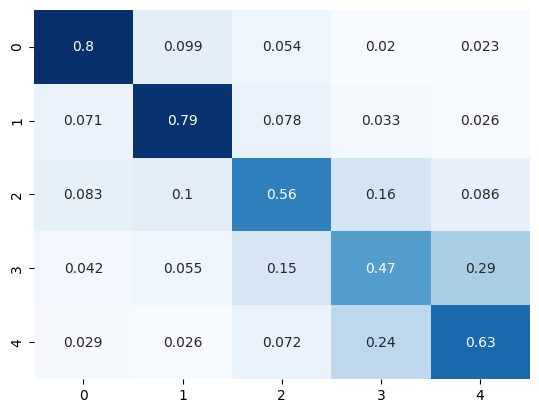

In [14]:
# Entraînement du modèle après la réduction de dimension
"""xgb_pca = XGBClassifier()
xgb_pca.fit(X_train_pca, y_train_resampled)"""

xgb_pca = joblib.load('Entrainement_modeles_tfidf/xgb_pca_tfidf.joblib')

# Affichage des scores
y_pred = xgb_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

"""joblib.dump(xgb_pca, 'Entrainement_modeles_tfidf/xgb_pca_tfidf.joblib')"""

### XGBoost optimisation des hyperparamètres

L'objectif est maintenant d'optimiser les performances de notre modèle en ajustant les hyperparamètres. Habituellement, je sélectionne 3 ou 4 hyperparamètres clés, en explorant d'abord un large éventail de valeurs, puis en affinant progressivement la grille de recherche pour approcher un minimum, même si celui-ci est local. Cependant, en raison du temps de calcul requis, je ne vais pas procéder à cette optimisation. En effet, pour une grille de recherche de 3x3 hyperparamètres avec une validation croisée à 3, il faudrait entraîner 81 modèles, ce qui prendrait environ 2 heures pour une seule exécution du code. Une optimisation des hyperparamètres aurait probablement permis d'améliorer légèrement l'accuracy et le F1-score pour chaque classe.

```python
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train_resampled)

print("Meilleurs paramètres : ", grid_search.best_params_)
```

```python
best_xgb = grid_search.best_estimator_

# Affichage des scores
y_pred = best_xgb.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)
```

### CONCLUSION

Les résultats obtenus sont globalement satisfaisants, surtout pour les classes 1 et 2 étoiles, qui sont relativement bien prédites avec des scores de précision et de rappel élevés. Cela indique que le modèle parvient bien à identifier les avis les plus négatifs, bien qu'il reste une marge d'amélioration.

En revanche, les classes 3, 4, et 5 étoiles sont prédictes avec moins de précision. Pour la classe 3 étoiles, on observe un rappel de 0.56, ce qui signifie que de nombreux avis de cette catégorie sont mal classés. Les classes 4 et 5 étoiles montrent également des faiblesses, avec des valeurs de F1-score plus basses que les classes 1 et 2. Cela pourrait être dû à une confusion entre ces classes, qui sont peut-être plus proches en termes de contenu textuel, rendant leur distinction plus difficile pour le modèle.

La matrice de confusion montre effectivement des erreurs fréquentes entre les classes adjacentes, comme des prédictions de classe 4 pour des avis de classe 5, et vice-versa. Cette confusion peut être attribuée à des similarités dans le texte des avis, surtout entre les avis neutres à positifs.

## Methodes plus avancée (deep learning)

In [15]:
y = df_clean['rating'].map(lambda x : x-1)
X_text_train, X_text_test, y_train, y_test = train_test_split(df_clean['review'], y, test_size=0.2, random_state=24)

### RNN

In [16]:
max_words = 10000
max_length = 500
embedding_dim = 200

# Tokenisation des avis
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text_train)
X_train = tokenizer.texts_to_sequences(X_text_train)
X_test = tokenizer.texts_to_sequences(X_text_test)

# Padding des séquences pour qu'elles aient la même longueur
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [17]:
"""# Construction du modèle RNN
rnn = Sequential()

rnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
rnn.add(LSTM(32, return_sequences=True))
rnn.add(Dropout(0.3))
rnn.add(GlobalAveragePooling1D())
rnn.add(Dense(5, activation='softmax'))

# Compilation du modèle
rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Entrainement_modeles_deep/rnn_classique_4.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

history = rnn.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=30, 
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

joblib.dump(history, 'Entrainement_modeles_deep/rnn_classique_history_4.joblib')"""

"# Construction du modèle RNN\nrnn = Sequential()\n\nrnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim))\nrnn.add(LSTM(32, return_sequences=True))\nrnn.add(Dropout(0.3))\nrnn.add(GlobalAveragePooling1D())\nrnn.add(Dense(5, activation='softmax'))\n\n# Compilation du modèle\nrnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\n# Entraînement du modèle\nearly_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)\nmodel_checkpoint = ModelCheckpoint('Entrainement_modeles_deep/rnn_classique_4.keras', monitor='val_accuracy', save_best_only=True, mode='max')\nreduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)\n\nhistory = rnn.fit(\n    X_train, y_train, \n    validation_data=(X_test, y_test),\n    epochs=30, \n    batch_size=64,\n    callbacks=[early_stopping, model_checkpoint, reduce_lr]\n)\n\njoblib.dump(history, 'Entrainement_modeles_deep/rnn_classique_history_4.

In [18]:
for i in range(1, 5):
    try:
        # Essayer de charger le modèle .h5
        rnn = load_model(f'Entrainement_modeles_deep/rnn_classique_{i}.h5')
    except:
        try:
            # Si le modèle .h5 échoue, essayer de charger le modèle .keras
            rnn = load_model(f'Entrainement_modeles_deep/rnn_classique_{i}.keras')
        except:
            # Si les deux tentatives échouent, afficher un message d'erreur
            print(f"Le modèle rnn_classique_{i} n'a pas pu être chargé.")
            continue  # Passer à l'itération suivante
    
    # Afficher le résumé du modèle si chargé avec succès
    rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 128)       │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177,031 (8.30 MB)

 Trainable params: 2,177,029 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 128)       │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,704,273 (25.57 MB)

 Trainable params: 2,234,757 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,469,516 (17.05 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 64)        │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,204,497 (23.67 MB)

 Trainable params: 2,068,165 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,136,332 (15.78 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500, 32)        │        29,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,089,969 (23.23 MB)

 Trainable params: 2,029,989 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,059,980 (15.49 MB)

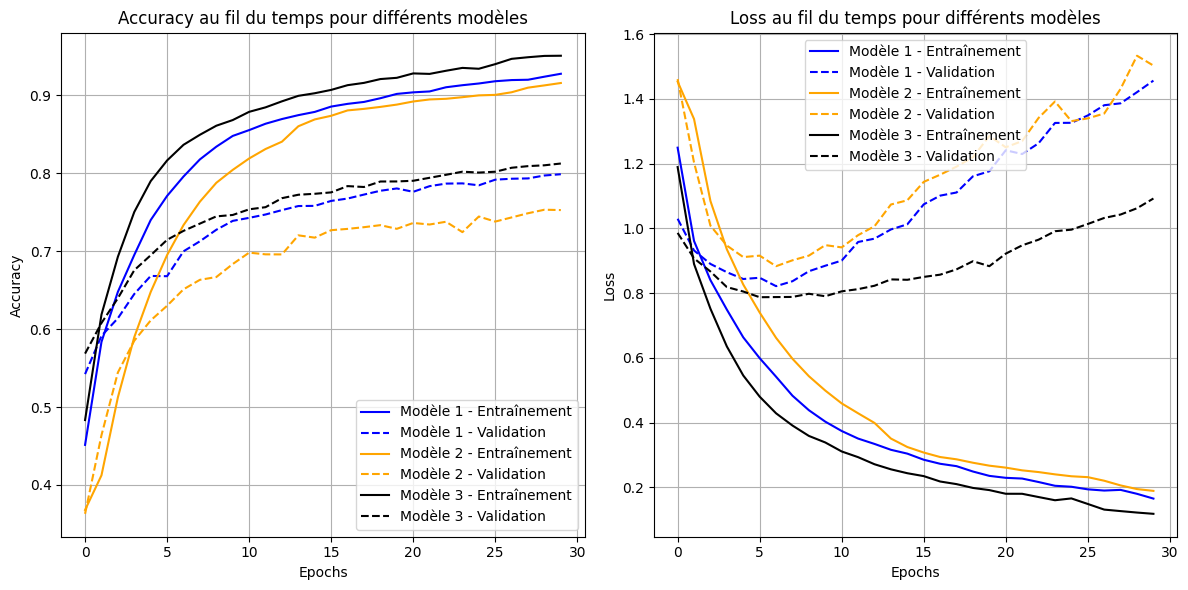

In [ ]:
colors = ['blue', 'orange', 'black'] 

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
# Charger et tracer les courbes de chaque modèle
for i in range(1, 4):
    history = joblib.load(f'Entrainement_modeles_deep/rnn_classique_history_{i}.joblib')

    plt.plot(history.history['accuracy'], label=f'Modèle {i} - Entraînement', color=colors[i-1])
    plt.plot(history.history['val_accuracy'], label=f'Modèle {i} - Validation', color=colors[i-1], linestyle='--')

# Ajouter des détails au graphique
plt.title('Accuracy au fil du temps pour différents modèles')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
# Charger et tracer les courbes de chaque modèle
for i in range(1, 4):
    history = joblib.load(f'Entrainement_modeles_deep/rnn_classique_history_{i}.joblib')

    plt.plot(history.history['loss'], label=f'Modèle {i} - Entraînement', color=colors[i-1])
    plt.plot(history.history['val_loss'], label=f'Modèle {i} - Validation', color=colors[i-1], linestyle='--')

# Ajouter des détails au graphique
plt.title('Loss au fil du temps pour différents modèles')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()  
plt.show()

466/466 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1726
           1       0.78      0.78      0.78      1094
           2       0.79      0.77      0.78      2273
           3       0.78      0.77      0.77      4410
           4       0.84      0.86      0.85      5400

    accuracy                           0.81     14903
   macro avg       0.81      0.81      0.81     14903
weighted avg       0.81      0.81      0.81     14903



<Axes: >

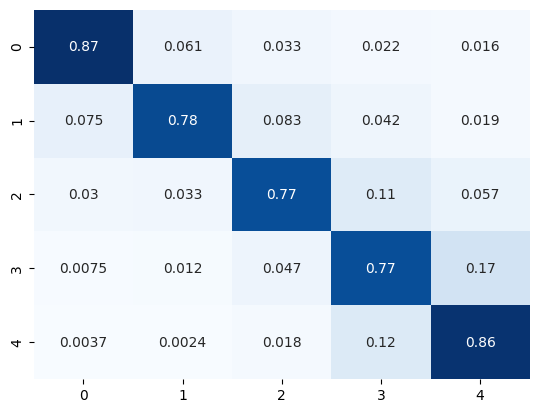

In [20]:
rnn = load_model(f'Entrainement_modeles_deep/rnn_classique_4.keras')

y_pred = np.argmax(rnn.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)

### RNN Bidirectionel

In [21]:
"""bi_rnn = Sequential()

bi_rnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
bi_rnn.add(Bidirectional(LSTM(32, return_sequences=True)))
bi_rnn.add(Dropout(0.4))
bi_rnn.add(GlobalAveragePooling1D())
bi_rnn.add(Dense(5, activation='softmax'))

# Compilation du modèle
bi_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Entrainement_modeles_deep/rnn_bidirectionnel.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)

history_bi = bi_rnn.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=30, 
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
joblib.dump(history_bi, 'Entrainement_modeles_deep/rnn_bidirectionnel_history.joblib')"""

"bi_rnn = Sequential()\n\nbi_rnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))\nbi_rnn.add(Bidirectional(LSTM(32, return_sequences=True)))\nbi_rnn.add(Dropout(0.4))\nbi_rnn.add(GlobalAveragePooling1D())\nbi_rnn.add(Dense(5, activation='softmax'))\n\n# Compilation du modèle\nbi_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\n# Entraînement du modèle\nearly_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)\nmodel_checkpoint = ModelCheckpoint('Entrainement_modeles_deep/rnn_bidirectionnel.keras', monitor='val_accuracy', save_best_only=True, mode='max')\nreduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)\n\nhistory_bi = bi_rnn.fit(\n    X_train, y_train, \n    validation_data=(X_test, y_test),\n    epochs=30, \n    batch_size=64,\n    callbacks=[early_stopping, model_checkpoint, reduce_lr]\n)\njoblib.dump(history_bi, 'Entrainem

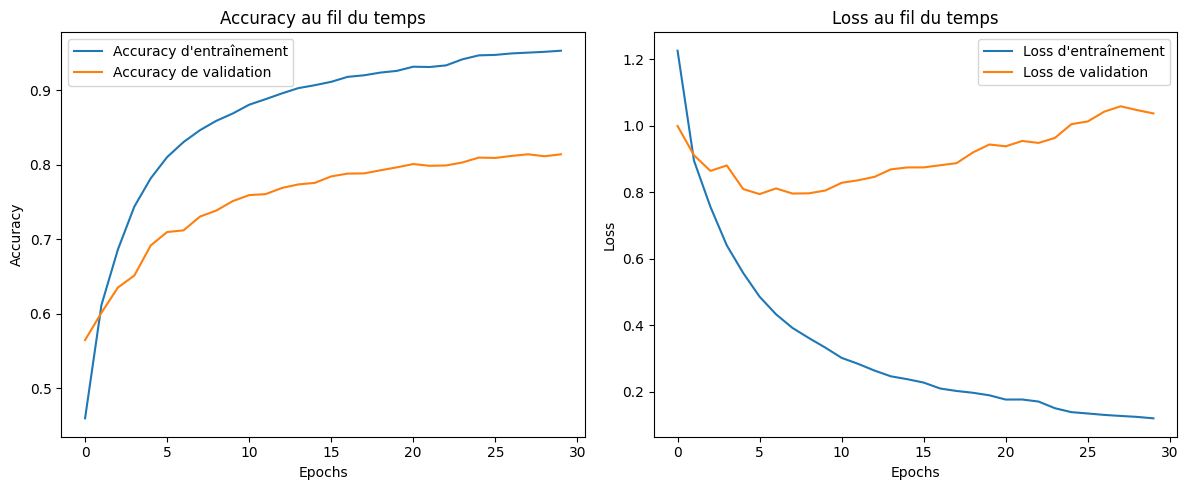

In [22]:
history_bi = joblib.load(f'Entrainement_modeles_deep/rnn_bidirectionnel_history.joblib')

plt.figure(figsize=(12, 5))

# Subplot pour l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bi.history['accuracy'], label='Accuracy d\'entraînement')
plt.plot(history_bi.history['val_accuracy'], label='Accuracy de validation')
plt.title('Accuracy au fil du temps')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot pour la loss
plt.subplot(1, 2, 2)
plt.plot(history_bi.history['loss'], label='Loss d\'entraînement')
plt.plot(history_bi.history['val_loss'], label='Loss de validation')
plt.title('Loss au fil du temps')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

466/466 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1726
           1       0.78      0.79      0.78      1094
           2       0.79      0.78      0.78      2273
           3       0.79      0.75      0.77      4410
           4       0.83      0.87      0.85      5400

    accuracy                           0.81     14903
   macro avg       0.81      0.81      0.81     14903
weighted avg       0.81      0.81      0.81     14903



<Axes: >

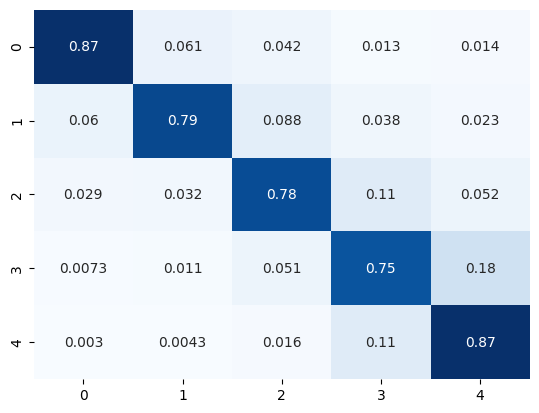

In [23]:
bi_rnn = load_model(f'Entrainement_modeles_deep/rnn_bidirectionnel.keras')

y_pred = np.argmax(bi_rnn.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, cbar=False)